In [10]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Turing
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CairoMakie
using PairPlots

In [12]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Define DataFrame object
data = DataFrame(
  year = Int[],
  open_magn_flux = Float64[],
  open_magn_flux_err = Float64[],
  ssa_open_magn_flux = Float64[],
  sunspots_num = Float64[],
  sunspots_err = Float64[],
  ssa_sunspots = Float64[]
)

# Open file and for each row write data into the DataFrame
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"] 

  for row in XLSX.eachrow(sheet)
    if isa(row[2], Number)
      push!(data, (
        year = row[2],
        open_magn_flux = row[3],
        open_magn_flux_err = row[4],
        ssa_open_magn_flux = row[5],
        sunspots_num = row[7],
        sunspots_err = row[8],
        ssa_sunspots = row[9]
      ))
    end
  end
end

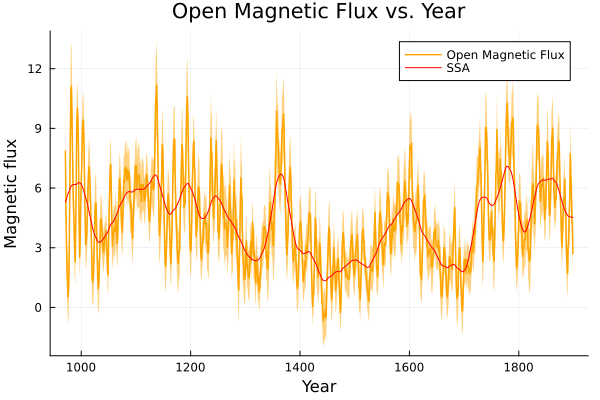

In [14]:
# PLOTTING OF THE OPEN MAGNETIC FLUX RECORDS FROM 971 TO 1899 (AD)

Plots.plot(data.year, data.open_magn_flux, ribbon = data.open_magn_flux_err, xlabel = "Year", ylabel = "Magnetic flux", 
    title = "Open Magnetic Flux vs. Year", label = "Open Magnetic Flux", linewidth = 1.5, color = "orange")
Plots.plot!(data.year, data.ssa_open_magn_flux, label = "SSA", linewidth = 1, color = "red")

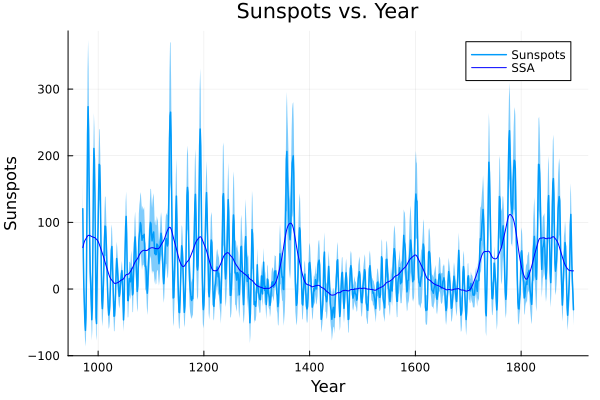

In [16]:
# PLOTTING OF THE SUNSPOT RECORDS FROM 971 TO 1899 (AD)

Plots.plot(data.year, data.sunspots_num, ribbon = data.sunspots_err, xlabel = "Year", ylabel = "Sunspots", 
    title = "Sunspots vs. Year", label = "Sunspots", linewidth = 1.5)
Plots.plot!(data.year, data.ssa_sunspots, label = "SSA", linewidth = 1, color = "blue")

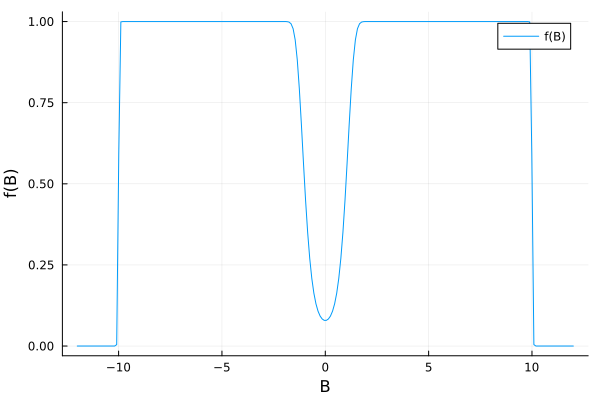

In [18]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
Plots.plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

##############################################################

# DIMENSION OF THE MAGNETIC FIELD???

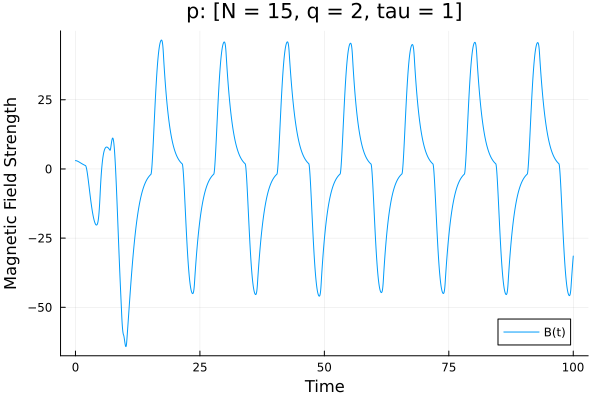

In [20]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 15
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
q = 2
p = [N, q, tau]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 100)
h(p, t) = [0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)

# Plot 
Plots.plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

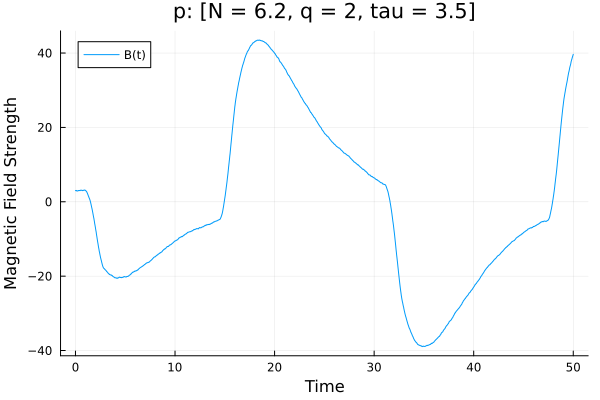

In [22]:
# SDDE PROBLEM WITHOUT PERIODIC MODULATION

# Define parameters
N = 6.2
T0 = 3
T1 = 0.1
tau = 3.5
T = T0 + T1
sigma = 0.04
B_max = 6.0

par = [N, T, tau, sigma, B_max]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 50)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  q = T / tau

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

function noise(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, par)
sol = solve(prob, EM(), dt = 0.01)

# Plot 
Plots.plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

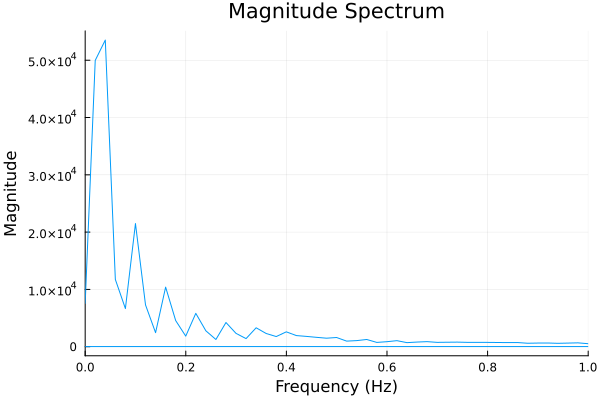

In [23]:
simulated_data = sol[1, :]
fourier_transform_sim = fft(simulated_data)
fourier_indeces = 1:6:120
fourier_sim = abs.(fourier_transform_sim[fourier_indeces])

Fs = 1 / ((sol.t[2] - sol.t[1]))
N = length(simulated_data)
freqs = fftfreq(N, Fs)

# Plot the magnitude spectrum
Plots.plot(freqs, abs.(fourier_transform_sim), xlabel="Frequency (Hz)", ylabel="Magnitude", title="Magnitude Spectrum", legend=false, xlims =(0, 1))

In [24]:
# FUNCTION FOR THE DISTANCE IN THE SABC ALGORITHM

function f_dist(θ::Vector{Float64}; type::Int64 = 1)
  prob = SDDEProblem(MagneticField, noise, B0, h, tspan, θ)
  sol = solve(prob, EM(), dt = 0.01)
  
  simulated_data = sol[1,:]

  fourier_transform = fft(simulated_data)
  fourier_indeces = 1:6:120
  fourier_stats = abs.(fourier_transform[fourier_indeces])

  rho = [euclidean(fourier_stats[i], fourier_sim[i]) for i in 1:length(fourier_stats)]
  
  return rho
end

f_dist (generic function with 1 method)

In [62]:
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type = 1)

display(result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 646.8642980700781 
[ Info: Population with 1000 particles initialised.
[ Info: Initial ϵ = [1.9274011360505328, 1.4812415736690199, 1.2582550261980492, 0.7834199414948594, 0.582492182167305, 0.5004783632403318, 0.45423666323749556, 0.4658390260124237, 0.4591938743343112, 0.4380519736944573, 0.4494091077837306, 0.4305002831089732, 0.42570647451369403, 0.4098972043389193, 0.41936445198873806, 0.4067365852853914, 0.4499469485726627, 0.4203760994298881, 0.43274544623641287, 0.4365014305109639]
[ Info: 2024-05-21T12:25:06.201 -- Starting population updates.


LoadError: InterruptException:

: 

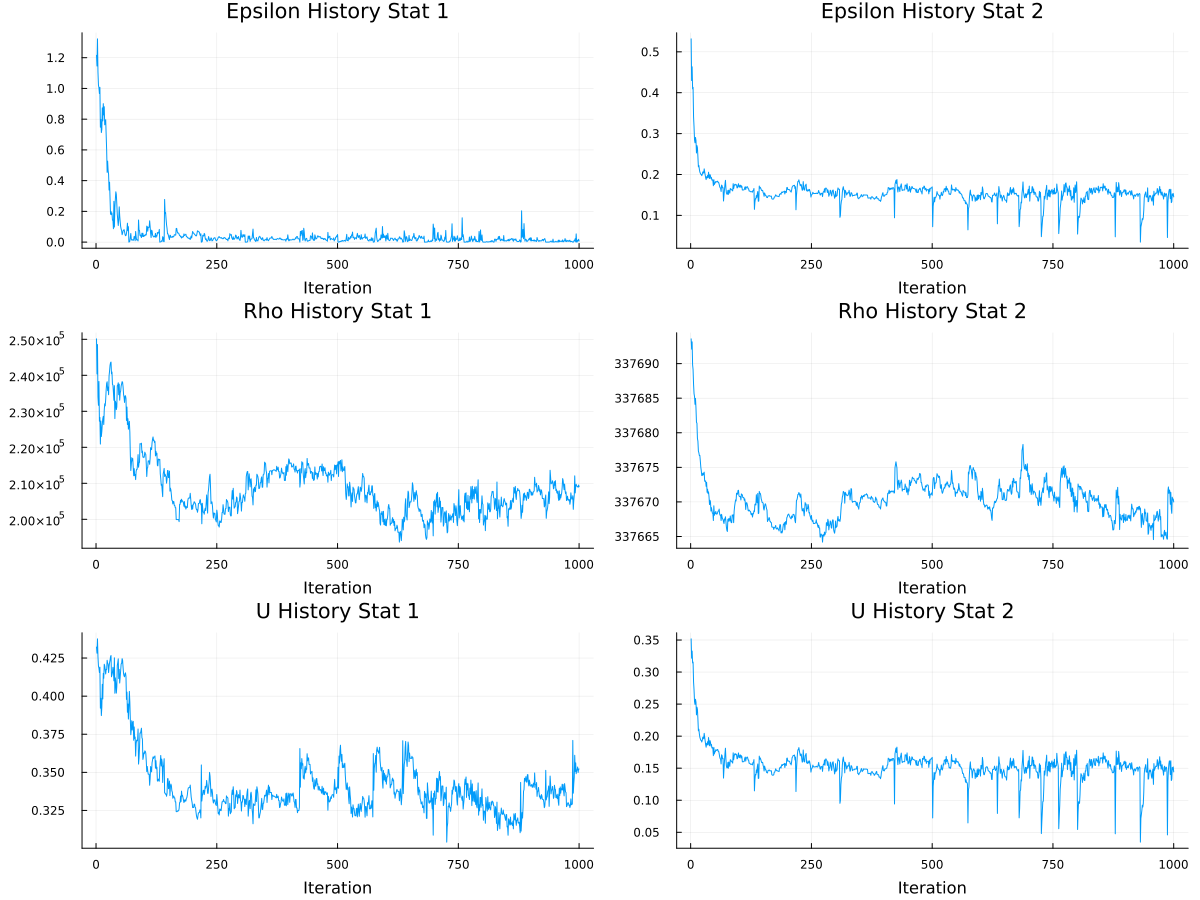

In [31]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [34]:
params = [6.2, 3.1, 3.5, 0.04, 6.0]
tspan = (0.0, 500.0)
B0 = [1.0, 0.0]

prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

observed_data = sol[1,:]
fourier_transform_obs = fft(observed_data)
fourier_indeces = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_indeces])

prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

function f_dist(θ::Vector{Float64}; type::Int64 = 1)
  prob = SDDEProblem(MagneticField, noise, B0, h, tspan, θ)
  sol = solve(prob, EM(), dt = 0.01)
  
  simulated_data = sol[1,:]

  fourier_transform = fft(simulated_data)
  fourier_indeces = 1:6:120
  fourier_stats = abs.(fourier_transform[fourier_indeces])

  rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
  
  return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type = 1)

display(result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 78.50761218935733 
[ Info: Population with 100 particles initialised.
[ Info: Initial ϵ = [1.2063569298557415, 0.8029202508492628, 1.4078476948059284, 2.518601126036566, 1.0855747958555584, 1.228421448396502, 0.7503854282952576, 1.4428171091366215, 0.8811852706318383, 0.8012543272292535, 0.5929467419836354, 0.6604755761217126, 12744.609717439344, 0.9369163890625922, 0.7373345153898567, 1.3768252498685636, 0.5704950235146294, 12344.867904910276, 0.9066732164863097, 1.515280607983048]
[ Info: 2024-05-20T18:53:42.959 -- Starting population updates.
[ Info: Resampling 2 (δ = 0.1) - ESS = 85.78563546774863
[ Info: Resampling 3 (δ = 0.1) - ESS = 81.3209761846312
┌ Info: 2024-05-20T18:59:48.180 -- Update 100 of 999 -- ETA: 00:54:43 
│  ϵ: [0.394, 0.2044, 0.3672, 0.3402, 0.2308, 0.2677, 0.1382, 0.09647, 0.2386, 0.3034, 0.2522, 0.2546, 0.04481, 0.2305, 0.2397, 0.1731, 0.2747, 0.06677, 0.224

Approximate posterior sample with 100 particles:
  - simulations used: 100000
  - average transformed distance: 0.1833
  - ϵ: [0.07665, 0.1348, 0.1288, 0.05607, 0.1368, 0.1209, 0.08284, 0.06706, 0.1719, 0.1698, 0.1864, 0.1815, 0.01583, 0.1686, 0.1821, 0.09129, 0.1812, 0.05067, 0.1777, 0.06828]
  - population resampling: 7
  - acceptance rate: 0.0147
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


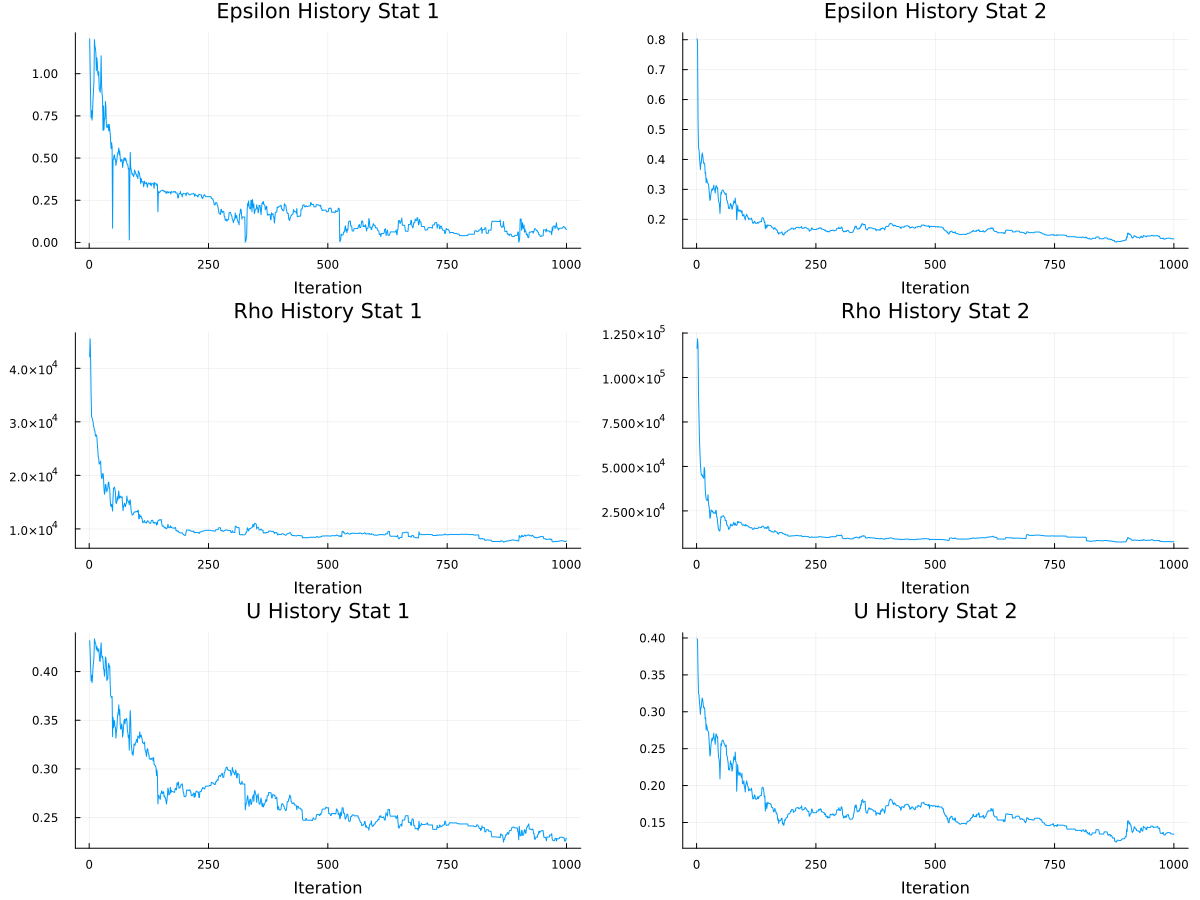

In [35]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

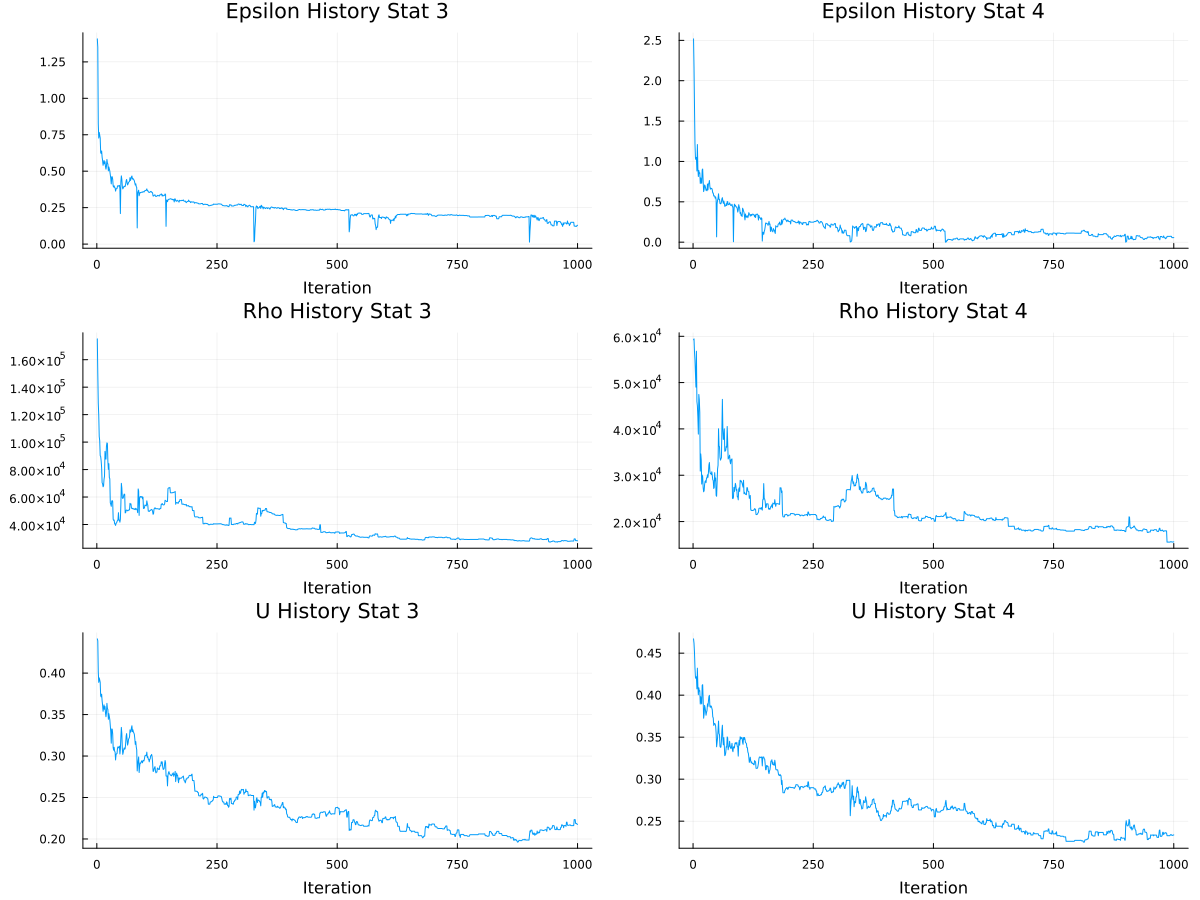

In [37]:
rho_stat3 = rho_singeps[3, :]
rho_stat4 = rho_singeps[4, :]

eps_stat3 = eps_singeps[3, :]
eps_stat4 = eps_singeps[4, :]

u_stat3 = u_singeps[3, :]
u_stat4 = u_singeps[4, :]

p1 = plot(eps_stat3, title="Epsilon History Stat 3", xlabel="Iteration", legend=false)
p2 = plot(eps_stat4, title="Epsilon History Stat 4", xlabel="Iteration", legend=false)
p3 = plot(rho_stat3, title="Rho History Stat 3", xlabel="Iteration", legend=false)
p4 = plot(rho_stat4, title="Rho History Stat 4", xlabel="Iteration", legend=false)
p5 = plot(u_stat3, title="U History Stat 3", xlabel="Iteration", legend=false)
p6 = plot(u_stat4, title="U History Stat 4", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [25]:
# ANALYSIS WITH SYNTETIC DATA
p = [6.2, 3.1, 3.5, 0.04, 6.0]  # Parameters N, T, tau, sigma, Bmax
tspan = (0.0, 10.0)
u0 = [1.0, 0.0]  # Initial condition: [B, dB]

# Create a DDEProblem object
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
# Solve the DDE using a suitable method
sol = solve(prob, EM(), dt = 0.01)
# Generate observational data
observed_data = sol[1, :]  # Add noise
fourier_transform_obs = fft(observed_data)
fourier_range_obs = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_range_obs])

# Define prior distributions for the parameters
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1, :]

    # Perform Fourier transform
    fourier_transform = fft(simulated_data)
    fourier_range = 1:6:120
    fourier_stats = abs.(fourier_transform[fourier_range])

    rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
    
    return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type=1)
println("Estimated parameters: ", result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 543.8919837323418 
[ Info: Population with 1000 particles initialised.
[ Info: Initial ϵ = [0.4976053334261942, 0.3374470151347981, 0.29573016778611805, 0.2955263436765196, 0.2885292204639262, 0.29121564806867534, 0.2952439979449903, 0.2941994559221939, 0.2921078308884229, 0.30224984852719966, 0.30466198088620255, 0.3069805899593909, 0.294223303231166, 0.2937144738149379, 0.3050135041362445, 0.3014461417834991, 0.3007357834024024, 0.3034371904535655, 0.3031671781832182, 0.298758562000043]
[ Info: 2024-05-21T13:03:26.355 -- Starting population updates.
┌ Info: 2024-05-21T13:04:55.053 -- Update 100 of 999 -- ETA: 00:13:17 
│  ϵ: [0.0004569, 0.0007865, 0.003281, 0.007966, 0.01097, 0.002381, 0.009322, 0.006407, 0.005668, 0.001936, 0.02221, 0.004532, 0.007645, 0.0148, 0.004998, 0.01766, 0.003224, 0.001915, 0.005887, 0.005682] 
└  mean transformed distance: 0.07168 
[ Info: Resampling 2 

Estimated parameters: Approximate posterior sample with 1000 particles:
  - simulations used: 1000000
  - average transformed distance: 0.02622
  - ϵ: [1.483e-8, 2.136e-8, 5.232e-8, 5.724e-7, 2.114e-7, 3.017e-8, 4.533e-8, 1.23e-7, 5.61e-8, 1.246e-8, 7.512e-6, 3.666e-8, 1.059e-7, 1.654e-7, 8.987e-8, 6.159e-8, 1.046e-7, 1.431e-8, 2.108e-7, 3.611e-8]
  - population resampling: 3
  - acceptance rate: 0.007793
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 



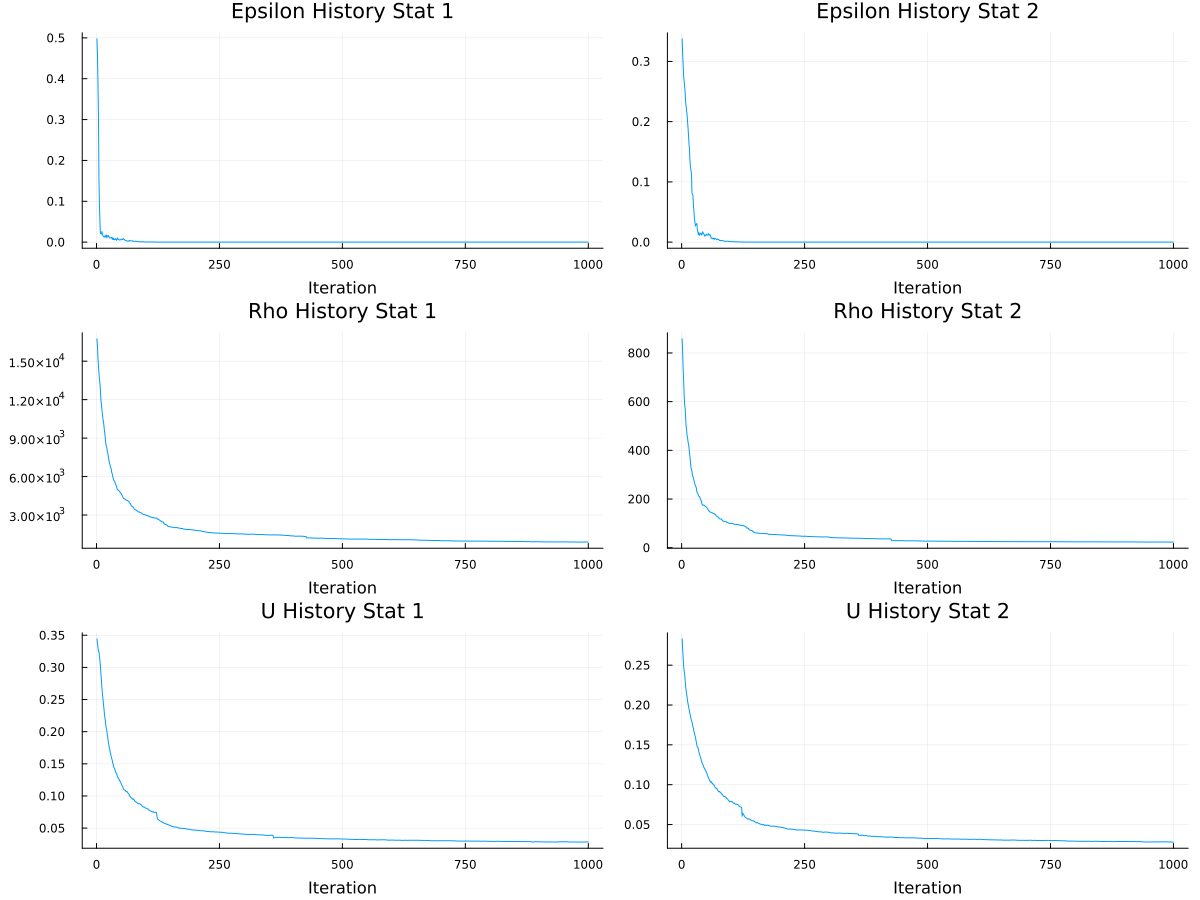

In [28]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = Plots.plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = Plots.plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = Plots.plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = Plots.plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = Plots.plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = Plots.plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [33]:
# Extract parameter samples for each parameter
pop_history = vec(pop_singeps)
param_samples = reshape(pop_history, 5, 1000)

N_value = param_samples[1, :]
T_value = param_samples[2, :]
tau_value = param_samples[3,:]
sigma_value = param_samples[4,:]
Bmax_value = param_samples[5, :]

posterior_params = DataFrame(;N_value, T_value, tau_value, sigma_value, Bmax_value)

1000×5 DataFrame
  Row │ N_value   T_value   tau_value  sigma_value  Bmax_value 
      │ Float64   Float64   Float64    Float64      Float64    
──────┼────────────────────────────────────────────────────────
    1 │  7.83025  3.18116     3.26784    0.0718481     4.58107
    2 │  5.33812  5.66645     2.71358    0.243178      1.20385
    3 │  7.8333   5.45849     1.89135    0.0505746     5.41161
    4 │  6.70017  5.73985     2.13493    0.047349      2.71756
    5 │  5.8977   3.80984     3.6775     0.135299      1.98762
    6 │  7.12631  3.49127     2.97415    0.127821      1.45484
    7 │  8.63989  1.93568     4.61638    0.0895106     3.706
    8 │  9.0736   2.75439     5.88692    0.0608409    13.8375
    9 │  7.35441  1.24644     4.33315    0.0846047     6.26465
   10 │  5.04503  6.09501     2.49377    0.0355019     9.66731
   11 │  8.31224  2.09195     4.77148    0.0601465     4.95969
  ⋮   │    ⋮         ⋮          ⋮           ⋮           ⋮
  991 │  4.20324  4.35481     4.28913    0.0451346     2.87675
  992 │  6.63457  3.49149     3.20083    0.114883      2.73407
  993 │  5.67919  6.13784     2.82158    0.0301739    11.9302
  994 │  6.36663  5.63594     2.09383    0.0177582     8.41977
  995 │  7.82055  3.24733     3.75087    0.152726      3.14082
  996 │  7.56827  2.09343     5.59242    0.0478175     8.14161
  997 │  6.84211  5.83289     2.01472    0.191889      1.60026
  998 │  4.45989  4.1949      3.70807    0.178293      2.67177
  999 │  7.45757  0.949176    3.98285    0.0305869     6.0788
 1000 │ 13.0416   1.84657     3.4528     0.0270224     1.61425
                                               979 rows omitted

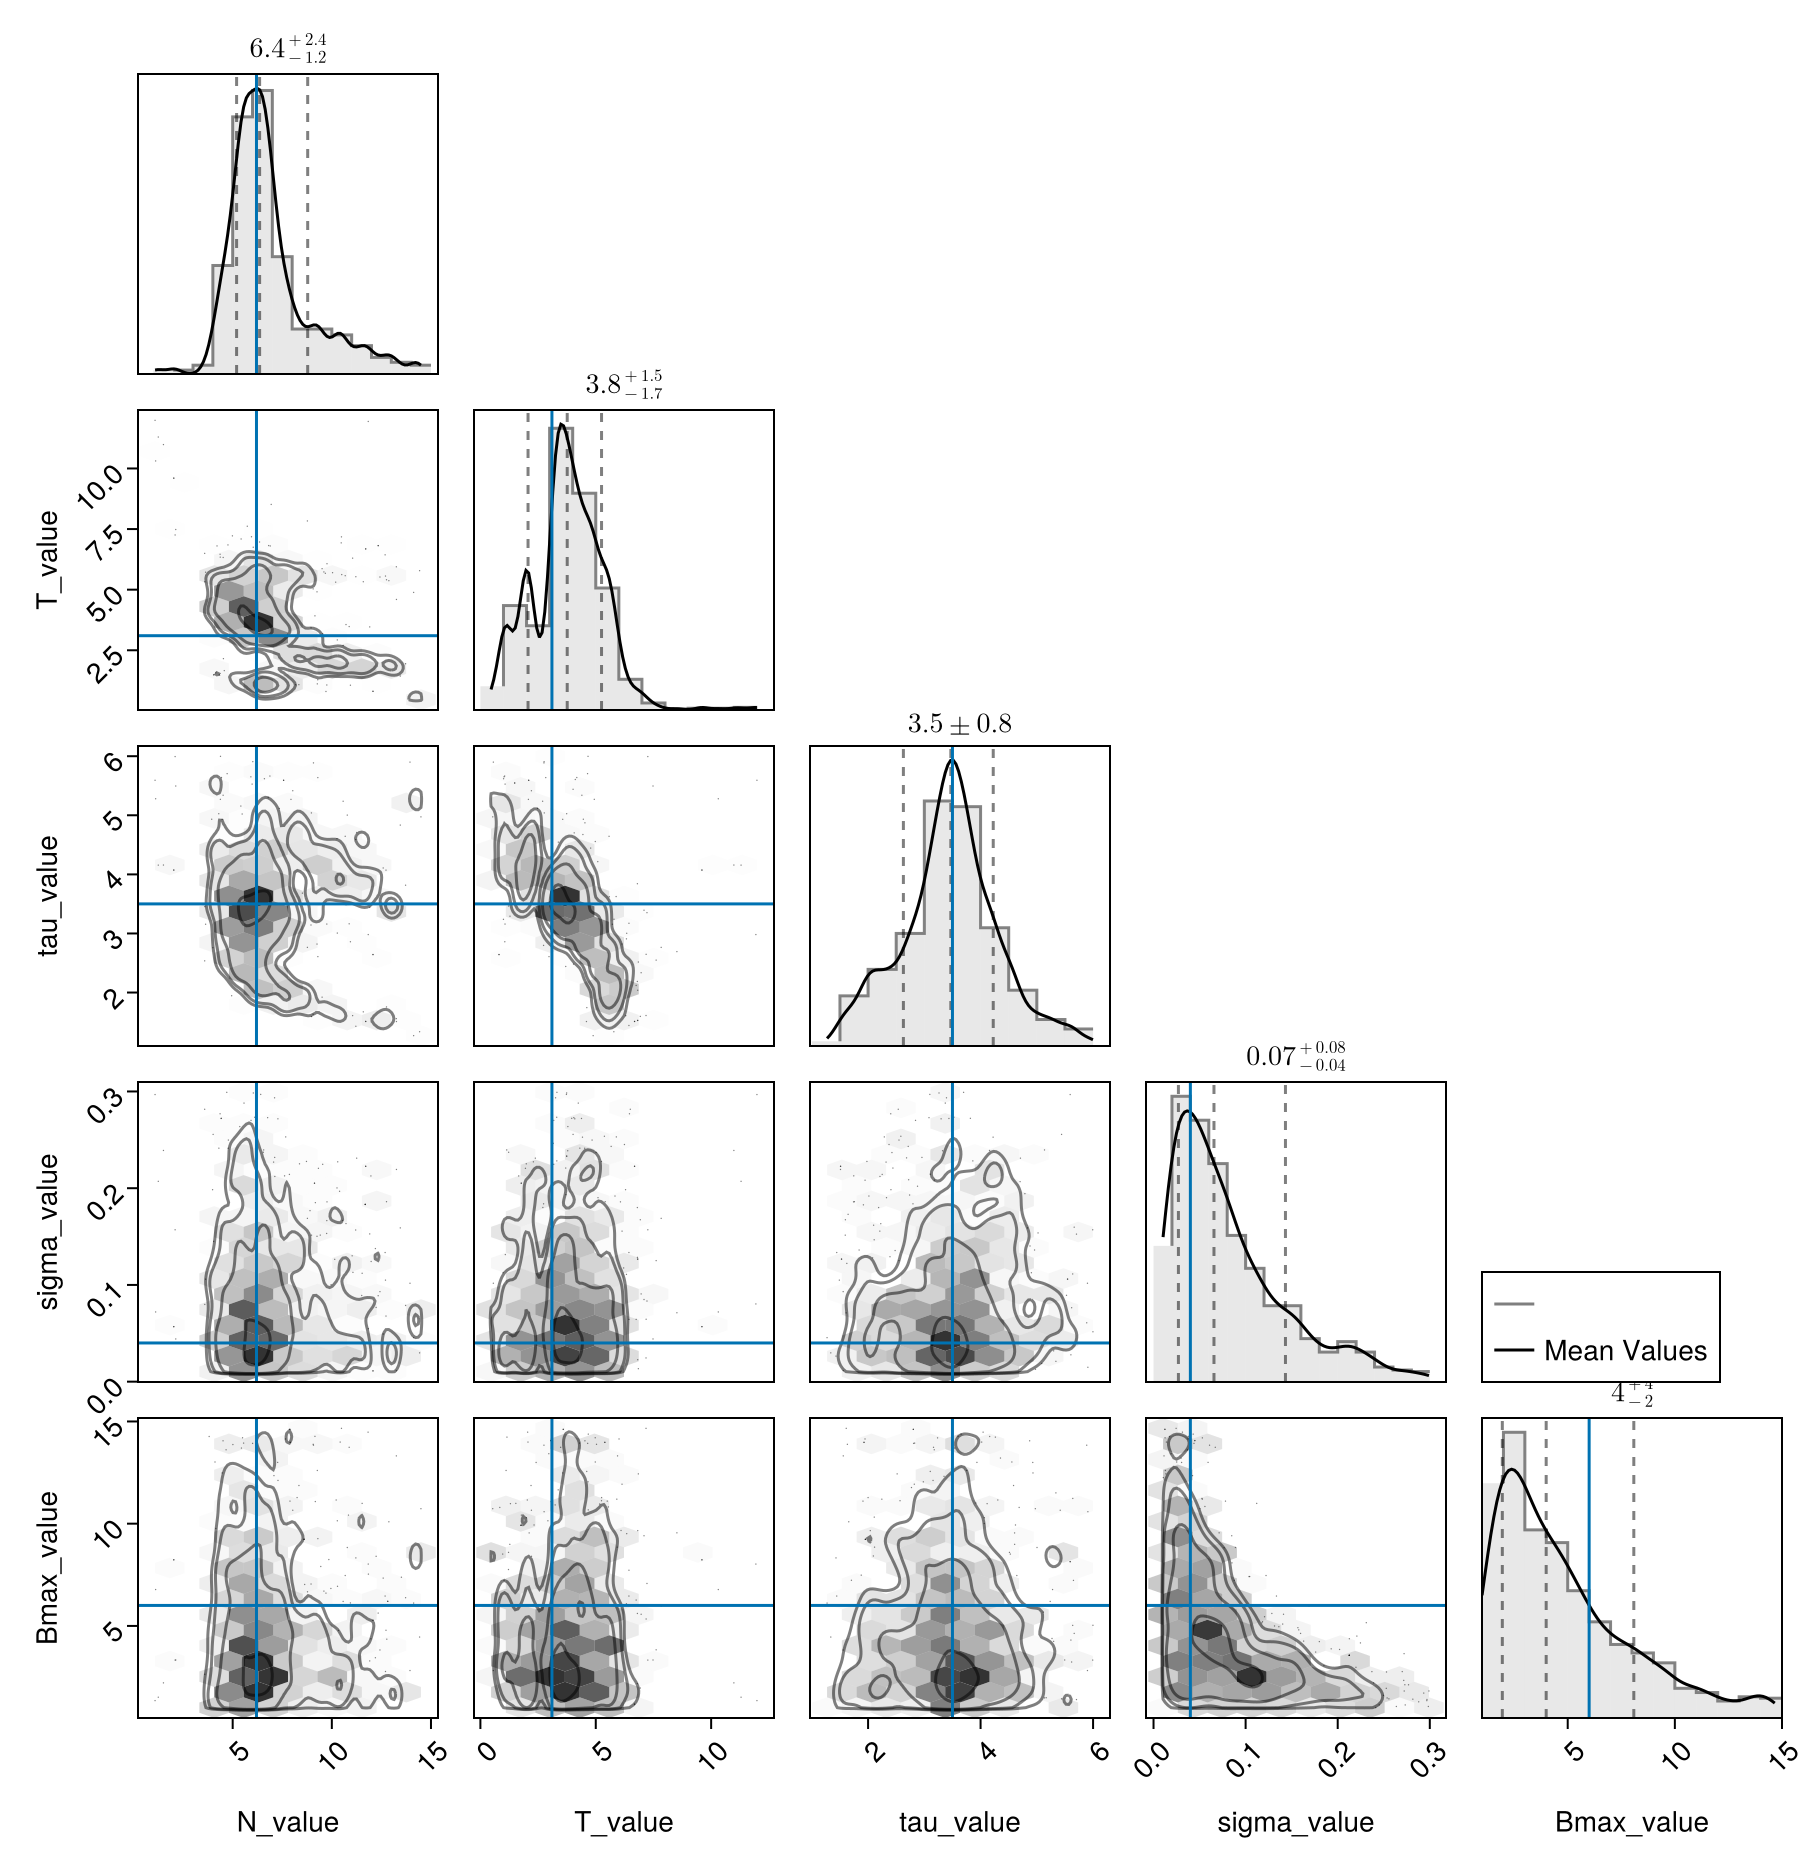

In [76]:
pairplot(
    posterior_params,
    PairPlots.Truth(
        (;
            N_value = 6.2,
            T_value = 3.1,
            tau_value = 3.5,
            sigma_value = 0.04,
            Bmax_value = 6.0
        ),
        label="Mean Values"
    )
) 

In [78]:
# ANALYSIS WITH SYNTETIC DATA
p = [6.2, 3.1, 3.5, 0.04, 6.0]  # Parameters N, T, tau, sigma, Bmax
tspan = (0.0, 50.0)
u0 = [1.0, 0.0]  # Initial condition: [B, dB]

# Create a DDEProblem object
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
# Solve the DDE using a suitable method
sol = solve(prob, EM(), dt = 0.01)
# Generate observational data
observed_data = sol[1, :]  # Add noise
fourier_transform_obs = fft(observed_data)
fourier_range_obs = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_range_obs])

# Define prior distributions for the parameters
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1, :]

    # Perform Fourier transform
    fourier_transform = fft(simulated_data)
    fourier_range = 1:6:120
    fourier_stats = abs.(fourier_transform[fourier_range])

    rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
    
    return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type=1)
println("Estimated parameters: ", result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 628.6995975332833 
[ Info: Population with 1000 particles initialised.
[ Info: Initial ϵ = [3.5540351889697988, 1.7267109337747442, 1.0534267785024398, 0.7785621149908588, 0.535846738555719, 0.6700250667771442, 0.46397132542931857, 0.47275206709287043, 0.49752496174408173, 0.44502850774791686, 0.45933972508456544, 0.4574152853066096, 0.434785607609473, 0.4621532122399957, 0.4632529663689581, 0.4480966618636873, 0.4368725077263938, 0.4486442243582909, 0.4386513818660282, 0.46333946043245944]
[ Info: 2024-05-21T14:27:24.576 -- Starting population updates.
┌ Info: 2024-05-21T14:34:52.268 -- Update 100 of 999 -- ETA: 01:07:04 
│  ϵ: [0.0263, 0.02364, 0.02855, 0.03382, 0.05494, 0.03964, 0.1619, 0.144, 0.1658, 0.1476, 0.1482, 0.1437, 0.1405, 0.1387, 0.149, 0.1386, 0.1408, 0.1419, 0.1477, 0.1396] 
└  mean transformed distance: 0.1678 


In [ ]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = Plots.plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = Plots.plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = Plots.plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = Plots.plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = Plots.plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = Plots.plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [ ]:
# Extract parameter samples for each parameter
pop_history = vec(pop_singeps)
param_samples = reshape(pop_history, 5, 1000)

N_value = param_samples[1, :]
T_value = param_samples[2, :]
tau_value = param_samples[3,:]
sigma_value = param_samples[4,:]
Bmax_value = param_samples[5, :]

posterior_params = DataFrame(;N_value, T_value, tau_value, sigma_value, Bmax_value)

In [ ]:
pairplot(
    posterior_params,
    PairPlots.Truth(
        (;
            N_value = 6.2,
            T_value = 3.1,
            tau_value = 3.5,
            sigma_value = 0.04,
            Bmax_value = 6.0
        ),
        label="Mean Values"
    )
) 